
# Richi — Rat Behavior Analysis

This notebook analyses **rat arrivals**, **minutes present**, and **food availability** across seasons using `dataset2.csv`.


**Season mapping (Southern Hemisphere):**
- **DJF = summer** (Dec–Feb)
- **MAM = autumn** (Mar–May)
- **JJA = winter** (Jun–Aug)
- **SON = spring** (Sep–Nov)


In [1]:

# If you already have these installed, you can skip this cell.
# In VS Code, you can also install via Terminal: pip install pandas numpy matplotlib seaborn
%pip install -q pandas numpy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:

import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Configuration ----------
# Option A (recommended): leave as None and place dataset2.csv next to this notebook.
# Option B: put your full path here as a string, for example:
# DATASET_PATH = r"C:\Users\Richi\Downloads\dataset2.csv"
DATASET_PATH = None

# ---------- Helpers ----------
def _probable_csv_locations():
    """Return probable locations for dataset2.csv, including the notebook folder,
    Downloads and Desktop on Windows/macOS/Linux."""
    candidates = []
    here = Path.cwd()
    candidates.append(here / "dataset2.csv")
    # Try parent (sometimes users run from a subfolder)
    candidates.append(here.parent / "dataset2.csv")
    # Typical user folders
    home = Path.home()
    for sub in ["Downloads", "Desktop"]:
        candidates.append(home / sub / "dataset2.csv")
    return candidates

def resolve_dataset_path():
    """Return a Path to dataset2.csv or raise a helpful error with instructions."""
    if DATASET_PATH:
        p = Path(DATASET_PATH)
        if p.exists():
            return p
        else:
            raise FileNotFoundError(
                f"Could not find file at DATASET_PATH={p}. Please check the path."
            )
    # Otherwise, try common locations
    for p in _probable_csv_locations():
        if p.exists():
            return p
    raise FileNotFoundError(
        "dataset2.csv not found.\n"
        "👉 Fix by doing one of the following:\n"
        "   1) Move dataset2.csv into the SAME folder as this notebook, OR\n"
        "   2) Set DATASET_PATH above to the full path, e.g.\n"
        r'      DATASET_PATH = r"C:\\Users\\Richi\\Downloads\\dataset2.csv"'
    )

def find_col(df, options, required=True):
    """Find the first column in df whose lowercase name matches one of the options.
    options: list[str] of candidate names (lowercase compared)
    If required and not found, raise a helpful error."""
    lower_map = {c.lower(): c for c in df.columns}
    for opt in options:
        if opt.lower() in lower_map:
            return lower_map[opt.lower()]
    if required:
        raise KeyError(
            "Missing expected column. Tried any of: "
            + ", ".join(options)
            + "\nYour columns are: "
            + ", ".join(map(str, df.columns))
        )
    return None

def to_season(dt_series):
    """Map dates to meteorological seasons (Southern Hemisphere)."""
    m = dt_series.dt.month
    # DJF (Dec=12, Jan=1, Feb=2) -> Summer
    return pd.Categorical(
        np.select(
            [
                m.isin([12,1,2]),    # DJF
                m.isin([3,4,5]),     # MAM
                m.isin([6,7,8]),     # JJA
                m.isin([9,10,11])    # SON
            ],
            ["Summer", "Autumn", "Winter", "Spring"],
            default="Unknown"
        ),
        categories=["Summer", "Autumn", "Winter", "Spring", "Unknown"],
        ordered=True
    )


In [3]:

csv_path = resolve_dataset_path()
print(f"Using data file: {csv_path}")

df_raw = pd.read_csv(csv_path)

print("Preview of data (first 5 rows):")
display(df_raw.head())

print("\nColumn names:")
print(list(df_raw.columns))


Using data file: c:\Users\Richi\Downloads\dataset2.csv
Preview of data (first 5 rows):


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0



Column names:
['time', 'month', 'hours_after_sunset', 'bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number']


In [4]:

df = df_raw.copy()

# Try to detect common column names
date_col   = find_col(df, ["date", "datetime", "timestamp", "time", "trial_date"])
arr_col  = find_col(df, ["rat_arrival_number", "arrivals", "rat_arrivals", "n_arrivals", "num_arrivals", "rat_count"])
mins_col = find_col(df, ["rat_minutes", "minutes_present", "minutes", "mins_present", "duration_minutes"])
food_col = find_col(df, ["food_availability", "food_available", "food_remaining", "food", "food_left", "food_avail"], required=False)

# Convert date to datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
if df[date_col].isna().all():
    raise ValueError(f"Could not parse any dates from column '{date_col}'. Please ensure it contains valid dates.")

# Create Season
df["Season"] = to_season(df[date_col])

# Keep only relevant columns (when available)
keep = [date_col, arr_col, mins_col, "Season"]
if food_col is not None:
    keep.append(food_col)
df_small = df[keep].rename(columns={arr_col: "Arrivals", mins_col: "MinutesPresent"})
if food_col is not None:
    df_small = df_small.rename(columns={food_col: "FoodAvailable"})

print("Cleaned columns preview:")
display(df_small.head())


Cleaned columns preview:


C:\Users\Richi\AppData\Local\Temp\ipykernel_6924\260457662.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


,time,Arrivals,MinutesPresent,Season,FoodAvailable
0,2017-12-26 16:13:00,0,0.0,Summer,4.000000
1,2017-12-26 16:43:00,0,0.0,Summer,4.000000
2,2017-12-26 17:13:00,0,0.0,Summer,4.000000
3,2017-12-26 17:43:00,0,0.0,Summer,4.000000
4,2017-12-26 18:13:00,0,0.0,Summer,3.753857


In [5]:

print("Summary by season (counts, mean, std):")
group_cols = ["Season"]
agg = {"Arrivals": ["count", "mean", "std"], "MinutesPresent": ["mean", "std"]}
if "FoodAvailable" in df_small.columns:
    agg["FoodAvailable"] = ["mean", "std"]

season_summary = df_small.groupby(group_cols).agg(agg)
display(season_summary)


Summary by season (counts, mean, std):


C:\Users\Richi\AppData\Local\Temp\ipykernel_6924\3803235583.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_summary = df_small.groupby(group_cols).agg(agg)


Arrivals                     MinutesPresent           FoodAvailable  \
           count      mean       std           mean       std          mean   
Season                                                                        
Summer       880  0.238636  0.918701       0.468750  1.670730      2.342955   
Autumn      1231  0.596263  1.064712       3.104549  8.642121      2.529199   
Winter        12  0.000000  0.000000       0.000000  0.000000      1.445554   
Spring         0       NaN       NaN            NaN       NaN           NaN   
Unknown        0       NaN       NaN            NaN       NaN           NaN   

                   
              std  
Season             
Summer   1.351931  
Autumn   1.107923  
Winter   0.572480  
Spring        NaN  
Unknown       NaN

<Figure size 640x480 with 0 Axes>

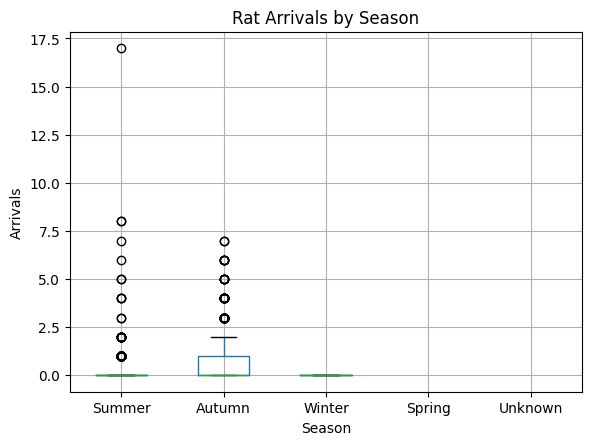

<Figure size 640x480 with 0 Axes>

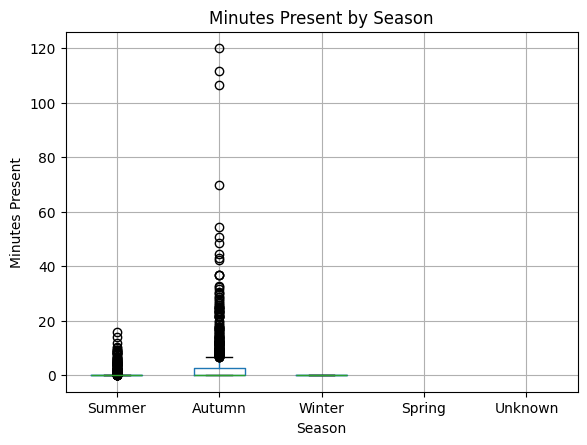

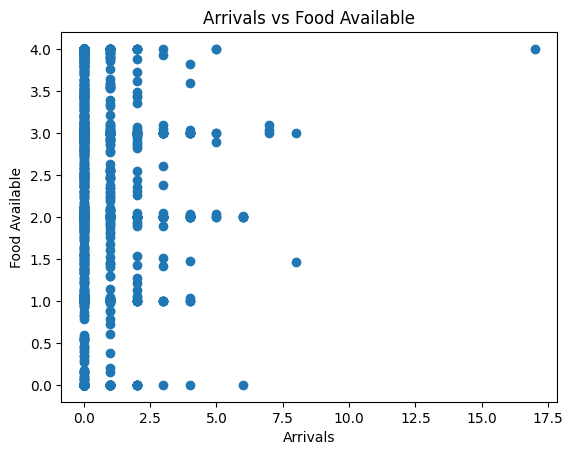

In [6]:

# Arrivals by Season (boxplot)
plt.figure()
df_small.boxplot(column="Arrivals", by="Season")
plt.title("Rat Arrivals by Season")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Arrivals")
plt.show()

# Minutes Present by Season (boxplot)
plt.figure()
df_small.boxplot(column="MinutesPresent", by="Season")
plt.title("Minutes Present by Season")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Minutes Present")
plt.show()

# Scatter: Arrivals vs Food (if available)
if "FoodAvailable" in df_small.columns:
    plt.figure()
    plt.scatter(df_small["Arrivals"], df_small["FoodAvailable"])
    plt.title("Arrivals vs Food Available")
    plt.xlabel("Arrivals")
    plt.ylabel("Food Available")
    plt.show()


In [7]:

# Optional: Save the cleaned subset for your report
out_path = Path("richie_rat_cleaned.csv")
df_small.to_csv(out_path, index=False)
print(f"Saved cleaned data to: {out_path.resolve()}")


Saved cleaned data to: C:\Users\Richi\Downloads\richie_rat_cleaned.csv


Winter vs Spring Summary:


C:\Users\Richi\AppData\Local\Temp\ipykernel_6924\1120547397.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ws_summary = winter_spring.groupby("Season").agg({


Arrivals           MinutesPresent      FoodAvailable         
           count mean  std           mean  std          mean      std
Season                                                               
Summer         0  NaN  NaN            NaN  NaN           NaN      NaN
Autumn         0  NaN  NaN            NaN  NaN           NaN      NaN
Winter        12  0.0  0.0            0.0  0.0      1.445554  0.57248
Spring         0  NaN  NaN            NaN  NaN           NaN      NaN
Unknown        0  NaN  NaN            NaN  NaN           NaN      NaN

<Figure size 640x480 with 0 Axes>

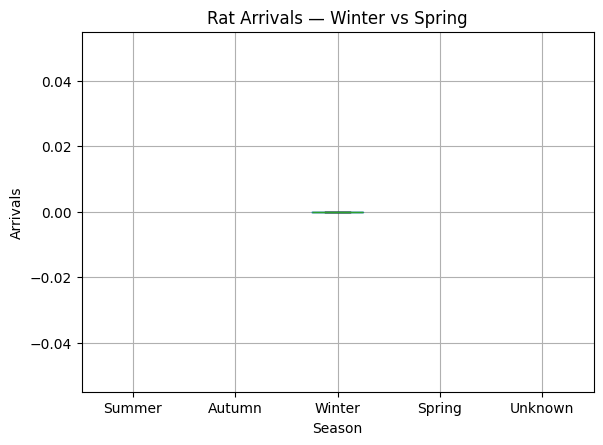

<Figure size 640x480 with 0 Axes>

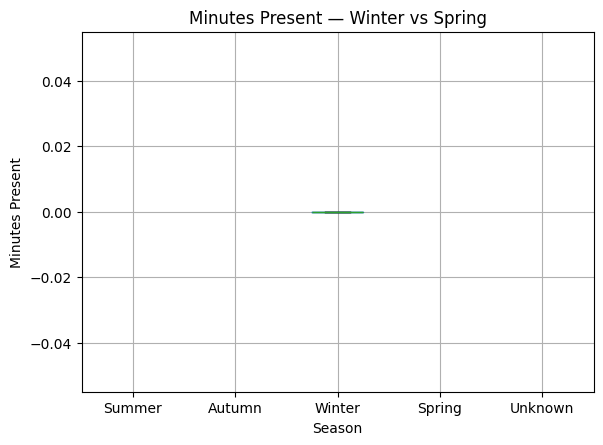

In [8]:
# --- Investigation Focus: Winter vs Spring only (as per project brief) ---

# Filter data for only Winter and Spring
winter_spring = df_small[df_small["Season"].isin(["Winter", "Spring"])]

# Display summary statistics for these two seasons
print("Winter vs Spring Summary:")
ws_summary = winter_spring.groupby("Season").agg({
    "Arrivals": ["count", "mean", "std"],
    "MinutesPresent": ["mean", "std"],
    "FoodAvailable": ["mean", "std"]
})
display(ws_summary)

# Optional: boxplot for visual comparison
import matplotlib.pyplot as plt

plt.figure()
winter_spring.boxplot(column="Arrivals", by="Season")
plt.title("Rat Arrivals — Winter vs Spring")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Arrivals")
plt.show()

plt.figure()
winter_spring.boxplot(column="MinutesPresent", by="Season")
plt.title("Minutes Present — Winter vs Spring")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Minutes Present")
plt.show()
